In [1]:
from pipeline import *
from utils import *
%load_ext autoreload
%autoreload 2

## 1. Read raw datacube and remove background & fringe

In [2]:
raw_datacube = Read_Raw_SITELLE_datacube("/home/qliu/data/A2465/5PrUCR/2345354p.fits",name="A2465C",
                                        wavl_mask=[[7950,8006],[8020,8040], [8230,8280]])
raw_datacube.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                 2048                                                  
NAXIS2  =                 2064                                                  
NAXIS3  =                  207                                                  
EXTEND  =                    T                                                  
DATE    = '2019-01-29'         / Creation date                                  
MASK    = 'False   '                                                            
FILETYPE= 'Calibrated Spectrum Cube' / Type of file                             
OBSERVAT= 'CFHT    '           / Observatory name                               
TELESCOP= 'CFHT 3.6m'          / Hawaii Big Island, Mauna Kea                   
INSTRUME= 'SITELLE '        

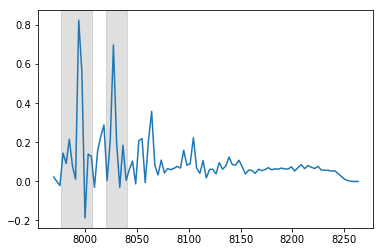

In [3]:
spec_med = [np.median(raw_datacube.raw_cube[k]) for k in range(len(raw_datacube.wavl))]
plt.axvspan(7976,8006,color='gray',alpha=0.25)
plt.axvspan(8020,8040,color='gray',alpha=0.25)
plt.plot(raw_datacube.wavl, spec_med)

In [4]:
raw_datacube.save_mask_edge(save_path = './proc/A2465C/')

Remove 2D background channel by channel.

In [5]:
raw_datacube.remove_background(box_size=128, save_path='./A2465C/fig_iso/bkg/128/', plot=False)

Removing background... Channel: 10
Removing background... Channel: 20
Removing background... Channel: 30
Removing background... Channel: 40
Removing background... Channel: 50
Removing background... Channel: 60
Removing background... Channel: 70
Removing background... Channel: 80
Removing background... Channel: 90


In [7]:
raw_datacube.save_fits(save_path = './proc/A2465C/', suffix="_bgsub")

Saving processed datacube and stacked field...


Check stack field. Note the strong fringe pattern.

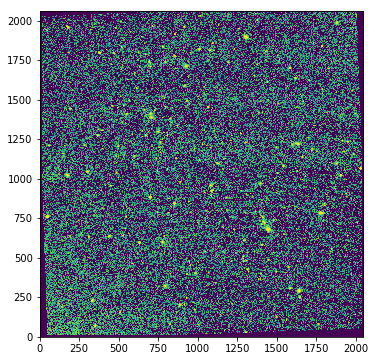

In [8]:
plt.figure(figsize=(6,6))
plt.imshow(raw_datacube.stack_field, norm=norm1, vmin=0, vmax=10)

Looking at some specific channels which suffer most. One choice is to not use / interpolate by nearby channels.

If True, Interpolate from adjacent channels to reduce fringe effects in later on detection.

In [6]:
# bad_channel = raw_datacube.interp_bad_channel(wavl_intp_range=[[7990,8000],[8022,8032]], interp=True)

In [9]:
channels,_ = raw_datacube.get_channel()
raw_datacube.remove_fringe(channels, k_size=(12,3), sn_source=3, method='LPF',
                           save_path='./A2465C/fig_iso/bkg/128/',
                           parallel=True, verbose=True, clear=True, plot=True)

./A2465C/fig_iso/bkg/128/ exists. Remove all the content.
Run iteration to clean fringes for channels: 
 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95]
'
Run low-pass filtering in parallel. Used when run on >20 channels.
Iteration 1 : 0 sources detected.
Iteration 2 : 918 sources detected.
Iteration 3 : 866 sources detected.

Iteration finished.


After fringe subtraction:

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
RA DEC : 339.9014, -

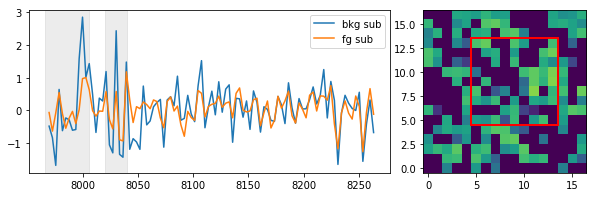

RA DEC : 339.8406, -5.7858


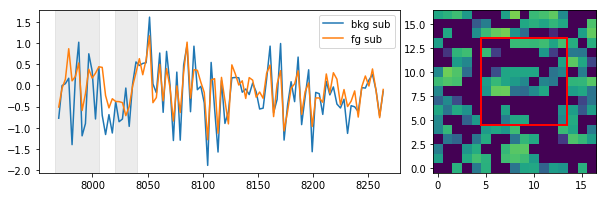

In [14]:
wcs_data = WCS(raw_datacube.header, naxis=2)
inspec_spaxel(901, 598, raw_datacube,w=4, wcs=wcs_data)
inspec_spaxel(1571, 706, raw_datacube, w=4, wcs=wcs_data)

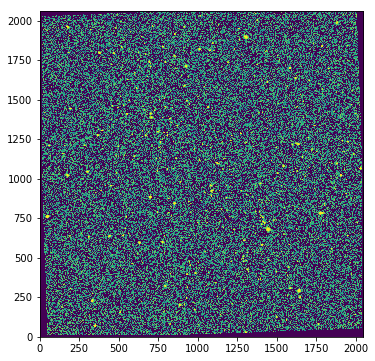

In [15]:
plt.figure(figsize=(6,6))
plt.imshow(raw_datacube.stack_field, norm=norm1, vmin=0, vmax=10)

In [16]:
raw_datacube.save_fits(save_path = './proc/A2465C/', suffix="_lpf")

Saving processed datacube and stacked field...


## 2. Extract source and spectra from datacube 

In [1]:
from pipeline import *
from utils import *
%load_ext autoreload
%autoreload 2

In [2]:
datacube = Read_Datacube('./proc/A2465C/A2465C_cube_bgsub.fits', z0=0.245, name='A2465C',
                         cube_supplementary='./proc/A2465C/A2465C_cube_lpf.fits',
                         wavl_mask=[[7950,8006],[8020,8040], [8230,8280]],
                         mask_edge='./proc/A2465C/Raw_stack_A2465C_mask.fits', mode="MMA")

[[7950, 8006], [8020, 8040], [8230, 8280]]  will be masked in making maximum map.


In [3]:
src_map, seg_map = datacube.ISO_source_detection(sn_thre=3, nlevels=64, contrast=0.01,
                                                 b_size=128, box=[3,3,7], closing=False,
                                                 save=True, save_path='./proc/A2465C/', suffix="_lpf")

Use the map of maximum of moving average (MMA) to detect source.
Box shape:  [3, 3, 7]
Detecting and deblending source...
Finish. Saved as ./proc/A2465C/A2465C_MMA_lpf.dat


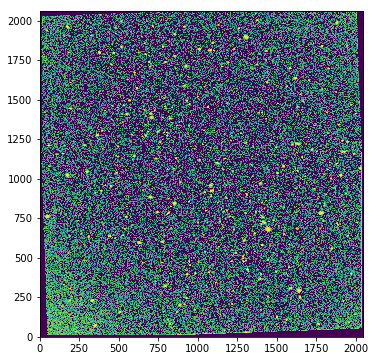

In [14]:
plt.figure(figsize=(6,6))
plt.imshow(datacube.src_map, norm=norm1, vmin=np.median(datacube.src_map),
           vmax=np.median(datacube.src_map)+20*mad_std(datacube.src_map))

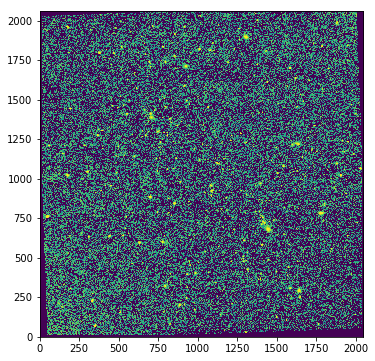

In [15]:
plt.figure(figsize=(6,6))
plt.imshow(datacube.stack_field, norm=norm1, vmin=np.median(datacube.stack_field),
           vmax=np.median(datacube.stack_field)+20*mad_std(datacube.stack_field))

In [16]:
datacube.ISO_spec_extraction_all(seg_map)

Extract spectra... 400/1410
Extract spectra... 800/1410
Extract spectra... 1200/1410


In [17]:
datacube.fit_continuum_all(model='GP', plot=True, save_path='./A2465C/fig_iso/fit_cont_MMA_lpf/', edge_ratio=0.1)

./A2465C/fig_iso/fit_cont_MMA_lpf/ exists. Remove all the content.
Fit spectra continuum ... 400/1410
Fit spectra continuum ... 800/1410
Fit spectra continuum ... 1200/1410
Skip spurious detection:  #1290 #1291 #1292 #1293 #1295 #1300 #1303 #1308 #1318 #1341 #1357 #1362 #1370 #1371 #1379 #1381 #1382 #1385 #1391 #1392 #1393 #1394 #1397 #1398 #1399 #1400 #1401 #1402 #1403 #1404 #1407 #1408 #1409 #1410  ... Replaced with random noise.
Continuum Fitting Finished!


In [18]:
datacube.save_spec_fits(save_path='./proc/A2465C', suffix="_lpf_all")

## 3. Generate Templates

In [1]:
from pipeline import *
from utils import *

In [ ]:
datacube = Read_Datacube('./proc/A2465C/A2465C_cube_lpf.fits', 
                         name='A2465C', z0=0.245, mode="MMA",
                         table='./proc/A2465C/A2465C_MMA.dat', 
                         seg_map='./proc/A2465C/A2465C_segm_MMA.fits')

In [10]:
datacube.generate_template(n_ratio=1, n_stddev=10, n_intp=2, 
                           temp_type="OII", ratio_prior="log-uniform", temp_model='gauss')
datacube.generate_template(n_ratio=8, n_stddev=10, n_intp=2, ratio_range = (2., 4.), 
                           temp_type="Hb-OIII", ratio_prior="log-uniform", temp_model='gauss')
datacube.generate_template(n_ratio=40, n_stddev=10, n_intp=2, ratio_range = (1., 8),
                           temp_type="Ha-NII", ratio_prior="log-uniform", temp_model='gauss')

Template: OII_gauss  Total Number: 10
Template: Hb-OIII_gauss  Total Number: 80
Template: Ha-NII_gauss  Total Number: 400


In [11]:
datacube.generate_template(n_ratio=1, n_stddev=10, n_intp=2,
                           temp_type="OII", ratio_prior="log-uniform", temp_model='box')
datacube.generate_template(n_ratio=8, n_stddev=10, n_intp=2, ratio_range = (2., 4.),
                           temp_type="Hb-OIII", ratio_prior="log-uniform", temp_model='box')
datacube.generate_template(n_ratio=40, n_stddev=10, n_intp=2, ratio_range = (1., 8), 
                           temp_type="Ha-NII", ratio_prior="log-uniform", temp_model='box')

Template: OII_box  Total Number: 1
Template: Hb-OIII_box  Total Number: 8
Template: Ha-NII_box  Total Number: 40


In [12]:
for mod in ['gauss','box']:
    for temp in ["Ha-NII", "Hb-OIII", "OII"]:
        datacube.Save_Template(save_path='./proc/template/', temp_type=temp, temp_model=mod)

Save A2465C templates for Ha-NII_gauss as Template-A2465C_Ha-NII_gauss.fits
Save A2465C templates for Hb-OIII_gauss as Template-A2465C_Hb-OIII_gauss.fits
Save A2465C templates for OII_gauss as Template-A2465C_OII_gauss.fits
Save A2465C templates for Ha-NII_box as Template-A2465C_Ha-NII_box.fits
Save A2465C templates for Hb-OIII_box as Template-A2465C_Hb-OIII_box.fits
Save A2465C templates for OII_box as Template-A2465C_OII_box.fits


## 4. Cross-correlation

In [2]:
from pipeline import *
from utils import *
%load_ext autoreload
%autoreload 2

In [3]:
datacube = Read_Datacube('./proc/A2465C/A2465C_cube_bgsub.fits', 
                         name='A2465C', z0=0.245, mode="MMA",
                         table='./proc/A2465C/A2465C_MMA_lpf.dat', 
                         seg_map='./proc/A2465C/A2465C_segm_MMA_lpf.fits')

datacube.read_spec('./proc/A2465C/A2465C-spec-MMA_lpf_all.fits')
datacube.Read_Template('./proc/template/', n_intp=2, name='A2465C')

Read Emission Line Template:
['./proc/template/Template-A2465C_Ha-NII_gauss.fits',
 './proc/template/Template-A2465C_Hb-OIII_gauss.fits',
 './proc/template/Template-A2465C_OII_gauss.fits',
 './proc/template/Template-A2465C_Ha-NII_box.fits',
 './proc/template/Template-A2465C_Hb-OIII_box.fits',
 './proc/template/Template-A2465C_OII_box.fits']


Detection #149  z: 0.245  sigma: 2.279  Peak R: 4.187  Detction S/N: 19.155 Peak S/N: 15.242


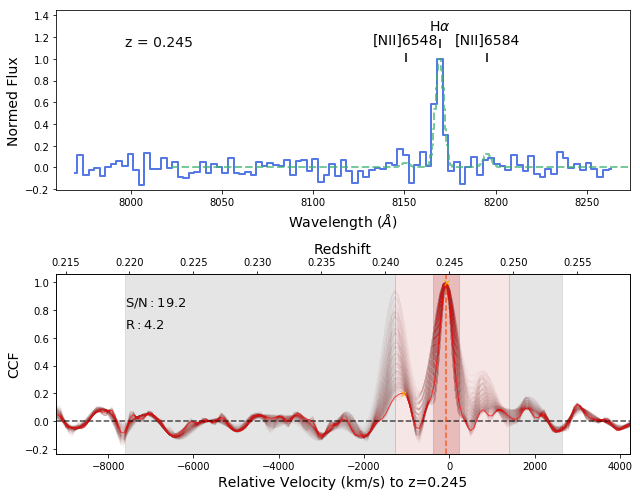

In [4]:
result = datacube.cross_correlation(149, temp_type="Ha-NII", const_window=False, edge=20, temp_model="gauss")

Detection #7  z: 0.217  sigma: 1.804  Peak R: 2.148  Detction S/N: 8.833 Peak S/N: 7.703


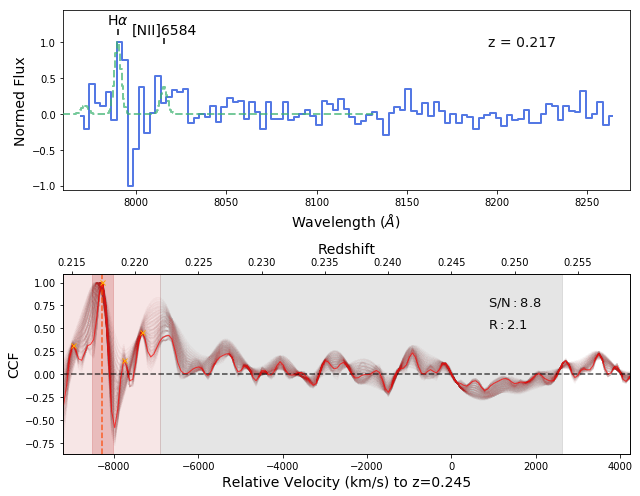

In [5]:
result = datacube.cross_correlation(7, temp_type="Ha-NII", edge=20, temp_model="gauss")

In [6]:
datacube.cross_correlation_all(temp_type="Ha-NII", temp_model="gauss", edge=20, verbose=False)
datacube.cross_correlation_all(temp_type="Hb-OIII", temp_model="gauss", edge=20, verbose=False)
datacube.cross_correlation_all(temp_type="OII", temp_model="gauss", edge=20, verbose=False)

Do cross-correlation using Ha-NII_gauss model templates...
Do cross-correlation using Hb-OIII_gauss model templates...
Do cross-correlation using OII_gauss model templates...


In [7]:
datacube.save_cc_result(save_path='./proc/A2465C/', suffix='_lpf')

Save cross-correlation results for A2465C as : ./proc/A2465C/A2465C-cc-MMA_lpf.pkl
Template used: ['Ha-NII_gauss', 'Hb-OIII_gauss', 'OII_gauss']


## 5. Select Candidate

In [1]:
from pipeline import *
from utils import *
%load_ext autoreload
%autoreload 2

In [8]:
datacube = Read_Datacube('./proc/A2465C/A2465C_cube_bgsub.fits', 
                         name='A2465C', z0=0.245, mode="MMA",
                         table='./proc/A2465C/A2465C_MMA_lpf.dat', 
                         seg_map='./proc/A2465C/A2465C_segm_MMA_lpf.fits',
                         mask_edge='./proc/A2465C/Raw_stack_A2465C_mask.fits')

datacube.deep_frame =  fits.getdata('./proc/A2465C/A2465C_DF.fits')
datacube.src_map = fits.getdata('./proc/A2465C/A2465C_MMA_lpf.fits')
datacube.read_spec('./proc/A2465C/A2465C-spec-MMA_lpf_all.fits')
datacube.Read_Template('./proc/template/', n_intp=2, name='A2465C')
datacube.read_cc_result('./proc/A2465C/A2465C-cc-MMA_lpf.pkl')

Read Emission Line Template:
['./proc/template/Template-A2465C_Ha-NII_gauss.fits',
 './proc/template/Template-A2465C_Hb-OIII_gauss.fits',
 './proc/template/Template-A2465C_OII_gauss.fits',
 './proc/template/Template-A2465C_Ha-NII_box.fits',
 './proc/template/Template-A2465C_Hb-OIII_box.fits',
 './proc/template/Template-A2465C_OII_box.fits']
Read cross-correlation results for A2465C from : ./proc/A2465C/A2465C-cc-MMA_lpf.pkl
Template used: ['Ha-NII_gauss', 'Hb-OIII_gauss', 'OII_gauss']


In [9]:
SNR_best_Ha_gauss = datacube.get_CC_result_best('SNR', 'Ha-NII_gauss')
SNR_best_OIII_gauss = datacube.get_CC_result_best('SNR', 'Hb-OIII_gauss')
SNR_best_OII_gauss = datacube.get_CC_result_best('SNR', 'OII_gauss')

z_best_OIII_gauss = datacube.get_CC_result_best('z_best', 'Hb-OIII_gauss')
flag_e_Ha_gauss = datacube.get_CC_result_best('flag_e', 'Ha-NII_gauss')

### Match with SDSS stars

In [10]:
cat_match = datacube.match_sdss_star(sep=3*u.arcsec, search_radius=7*u.arcmin, band='rmag')

c_match_star = SkyCoord(ra=cat_match["RA_ICRS"], dec=cat_match["DE_ICRS"])
star_match_pos = np.array(c_match_star.to_pixel(datacube.wcs, origin=0)).T

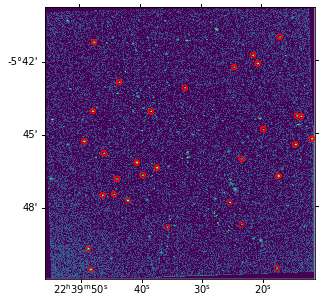

In [11]:
plt.figure(figsize=(5,5))
ax = plt.subplot(projection=datacube.wcs)
plt.scatter(star_match_pos[:,0], star_match_pos[:,1], s=25, facecolor="none", edgecolor="r")
plt.imshow(datacube.src_map, norm=norm1, vmin=np.median(datacube.src_map), vmax=1)

### Measure distance

In [12]:
dist_to_edge = measure_dist_to_edge(datacube.table, datacube.mask_edge, pad=200)

### Measure EW

(81.57498578681299, 10.307183804704824)

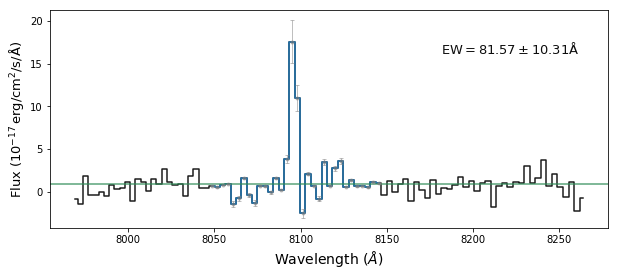

In [11]:
datacube.estimate_EW(152, sigma=5, MC_err=True)

(146.900818260249, 20.99080315110287)

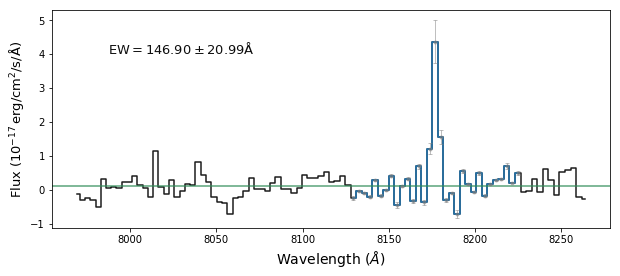

In [52]:
datacube.estimate_EW(210, sigma=5, MC_err=True)

In [13]:
datacube.estimate_EW_all(MC_err=True, sigma=5)

Measure EW... 400/1410
Measure EW... 800/1410
Measure EW... 1200/1410


In [15]:
bad_channel,_ = datacube.get_channel([[7950,8006],[8020,8040], [8230,8280]])
max_channel = np.argmax(datacube.obj_specs_opt, axis=1) + 1
strong_sky = np.array([max_ch in bad_channel for max_ch in max_channel])
low_cont = np.median(datacube.obj_specs_opt, axis=1) < 0.1
good_line = ~(strong_sky & low_cont)# & (max_channel!=10)

### Conditions

In [17]:
EW_cond = (datacube.EWs > datacube.EW_stds) & (datacube.EWs > 5)
edge_cond = dist_to_edge > 10

SNR_min_gauss = np.min([SNR_best_Ha_gauss, SNR_best_OIII_gauss, SNR_best_OII_gauss], axis=0)

SNR_cond_A = (SNR_best_Ha_gauss > 10) & (SNR_best_OII_gauss>3) 
sn_B = 5
SNR_cond_B = (SNR_best_Ha_gauss > sn_B) & (SNR_best_Ha_gauss <= 10) & (SNR_best_OII_gauss>sn_B)

zmin_OIII = datacube.wavl.min()/4959-1
# SN OIII > 5, SN OIII > SN Ha, SN OIII > SN OII 
SNR_cond_C = (SNR_best_OIII_gauss > np.max([sn_B*np.ones_like(datacube.obj_nums), SNR_best_Ha_gauss], axis=0)) \
            & (SNR_best_OII_gauss>3) & (z_best_OIII_gauss>zmin_OIII)

save = True
for v in ['A', 'B', 'C']:
    SN_cond_v = {'A':SNR_cond_A, 'B':SNR_cond_B, 'C':SNR_cond_C}
    type_v = {'A':"Ha-NII", 'B':"Ha-NII", 'C':"Hb-OIII"}

    num_c = datacube.obj_nums[EW_cond & SN_cond_v[v] & edge_cond & good_line]

    # remove stars and possible artifacts
    num_c = np.setdiff1d(num_c, np.concatenate([cat_match["NUMBER"].data, datacube.num_spurious]))
    print("%s: %d candidates:"%(v,len(num_c)), num_c)
        
    if save:
        save_path = './A2465C/fig_iso/candidate_lpf/%s'%v
        check_save_path(save_path, clear=True)
        for k, num in enumerate(num_c):
            if np.mod(k+1, 30)==0: print("Plot: %d/%d"%(k+1, len(num_c)))
            datacube.plot_candidate(num, temp_type=type_v[v], temp_model="gauss")
            plt.savefig(os.path.join(save_path, "#%d.png"%num),dpi=75)
            plt.close()
                         
if save:            
    check_save_path('./A2465C/fig_iso/candidate_lpf/V', clear=True)

A: 52 candidates: [ 116  123  167  205  240  243  307  327  374  383  423  443  488  504
  517  534  546  555  562  578  583  589  621  625  631  649  714  748
  768  836  845  849  851  885  975 1037 1156 1171 1215 1243 1289 1325
 1326 1327 1331 1338 1339 1349 1350 1351 1352 1353]
./A2465C/fig_iso/candidate_lpf/A exists. Remove all the content.
Plot: 30/52
B: 77 candidates: [   8   29   76   78   83   93   94  143  160  161  163  170  201  214
  230  231  286  302  321  405  413  454  462  468  492  501  502  514
  518  519  528  532  535  539  540  559  571  586  596  598  599  610
  633  651  656  659  663  676  679  680  733  766  769  774  778  790
  794  807  813  817  819  840  842  886  892  924  964  966 1006 1011
 1014 1075 1077 1150 1151 1190 1218]
./A2465C/fig_iso/candidate_lpf/B exists. Remove all the content.
Plot: 30/77
Plot: 60/77
C: 24 candidates: [  75   78   93  160  161  170  321  407  413  468  496  519  609  620
  663  677  819  886  966  983 1151 1190 1215 1311]


Detection #426  z: 0.246  sigma: 5.607  Peak R: 3.973  Detction S/N: 19.355 Peak S/N: 13.488


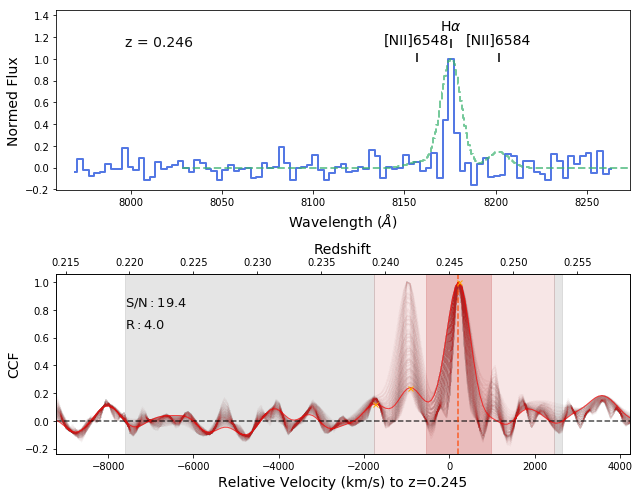

In [35]:
result = datacube.cross_correlation(426, temp_type="Ha-NII", edge=20, const_window=False, temp_model="gauss")

## 6. Measure Centroid

In [1]:
from pipeline import *
from utils import *

%load_ext autoreload
%autoreload 2

In [2]:
datacube = Read_Datacube('./proc/A2465C/A2465C_cube_lpf.fits', 
                         name='A2465C', z0=0.245, mode="MMA",
                         table='./proc/A2465C/A2465C_MMA_lpf.dat', 
                         seg_map='./proc/A2465C/A2465C_segm_MMA_lpf.fits',
                         deep_frame='./proc/A2465C/A2465C_DF.fits',
                         mask_edge='./proc/A2465C/Raw_stack_A2465C_mask.fits')

datacube.get_wcs()
datacube.read_cluster_boundary("./A2465C/A2465C_bound_v2.fits")
datacube.src_map = fits.open('./proc/A2465C/A2465C_MMA_lpf.fits')[0].data
datacube.read_spec('./proc/A2465C/A2465C-spec-MMA_lpf_all.fits')
datacube.Read_Template('./proc/template/', n_intp=2, name='A2465C')
datacube.read_cc_result('./proc/A2465C/A2465C-cc-MMA_lpf.pkl')

Read Emission Line Template:
['./proc/template/Template-A2465C_Ha-NII_gauss.fits',
 './proc/template/Template-A2465C_Hb-OIII_gauss.fits',
 './proc/template/Template-A2465C_OII_gauss.fits',
 './proc/template/Template-A2465C_Ha-NII_box.fits',
 './proc/template/Template-A2465C_Hb-OIII_box.fits',
 './proc/template/Template-A2465C_OII_box.fits']
Read cross-correlation results for A2465C from : ./proc/A2465C/A2465C-cc-MMA_lpf.pkl
Template used: ['Ha-NII_gauss', 'Hb-OIII_gauss', 'OII_gauss']


In [3]:
el_C = glob.glob("./A2465C/fig_iso/candidate_lpf/C/#*.png")
np.sort(np.array([re.compile(r'\d+').findall(el)[-1] for el in el_C]).astype("int"))

array([663, 677])

In [4]:
el_v = glob.glob("./A2465C/fig_iso/candidate_lpf/V/#*.png")
Num_v_all = np.sort(np.array([re.compile(r'\d+').findall(el)[-1] for el in el_v]).astype("int"))
Num_v_all

array([  29,   76,   78,   94,  116,  123,  143,  160,  161,  163,  167,
        170,  201,  205,  214,  230,  231,  240,  243,  286,  302,  307,
        321,  327,  374,  383,  405,  413,  423,  443,  454,  462,  468,
        488,  492,  501,  502,  504,  514,  517,  518,  519,  528,  532,
        534,  535,  539,  540,  546,  555,  559,  562,  571,  578,  583,
        586,  589,  596,  598,  599,  610,  621,  625,  631,  633,  649,
        656,  659,  663,  676,  680,  714,  733,  748,  766,  768,  769,
        774,  778,  790,  794,  807,  813,  817,  819,  836,  840,  842,
        845,  849,  851,  885,  886,  892,  924,  964,  966,  975, 1006,
       1011, 1014, 1037, 1075, 1077, 1150, 1151, 1156, 1171, 1190, 1215,
       1218, 1243, 1325, 1326, 1327, 1331, 1338, 1339, 1349, 1350, 1351,
       1352, 1353])

In [5]:
id_BCG1 = np.argmin((datacube.table["xcentroid"]-707)**2 + (datacube.table["ycentroid"]-1385)**2)
id_BCG2 = np.argmin((datacube.table["xcentroid"]-1446)**2 + (datacube.table["ycentroid"]-679)**2)
pos_BCG = datacube.assign_BCG_position(id_BCG=[id_BCG1,id_BCG2])

ra_BCG1, dec_BCG1 = datacube.wcs.all_pix2world(datacube.pos_BCG[0][0], datacube.pos_BCG[0][1], 0)
ra_BCG2, dec_BCG2 = datacube.wcs.all_pix2world(datacube.pos_BCG[1][0], datacube.pos_BCG[1][1], 0)
datacube.assign_BCG_coordinate(((ra_BCG1,dec_BCG1),(ra_BCG2,dec_BCG2)))

BCG1 coordinate:  22h39m40.487s -05d43m26.3742s
BCG2 coordinate:  22h39m24.5465s -05d47m17.6289s


Error of light-wighted centroid: $\sigma_{\left<x\right>} = \Sigma_j \frac{\sigma^2_{I_j} \cdot (x_j-\left<x\right>)^2}{\Sigma_i I_i^2}$

http://ugastro.berkeley.edu/infrared09/PDF-2009/centroid-error.pdf

In [57]:
self = datacube
ind = np.where(self.obj_nums==201)[0][0]
        
obj = Obj_detection(self.table[ind], cube=self.cube, seg_map=dilation(self.seg_map),
                    deep_frame=self.deep_frame, mask_edge=self.mask_edge)

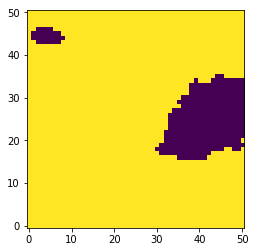

In [64]:
plt.imshow(obj.seg_tot)

stddev emission: 0.016 / continuum: 0.005
Centroid EM: (1442.04+/-0.01, 255.23+/-0.01)
Centroid CON: (1442.23+/-0.01, 255.45+/-0.01)


{'diff_angle': 39.72288320094526,
 'cen_offset': 0.29155985419726527,
 'diff_angle_std': 2.6317140287635126,
 'cen_offset_std': 0.013858812617604114,
 'pa': 319.42373760794123,
 'clus_cen_angle': 359.1466208088865,
 'dist_clus_cen': 421.3739346757642}

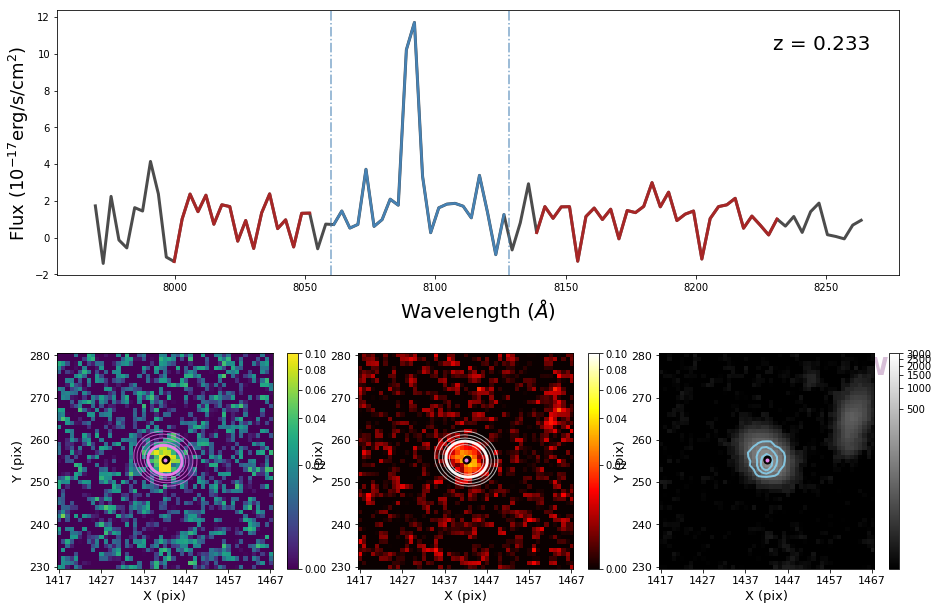

In [6]:
num = 167
datacube.centroid_analysis(num, centroid_type="APER", smooth=False)

stddev emission: 0.018 / continuum: 0.004
Centroid EM: (1000.86+/-0.14, 372.94+/-0.35)
Centroid CON: (1002.53+/-0.03, 372.91+/-0.05)


{'diff_angle': 35.322721144927925,
 'cen_offset': 1.671223368088637,
 'diff_angle_std': 12.23815273165441,
 'cen_offset_std': 0.14654949911254353,
 'pa': 268.97720470533704,
 'clus_cen_angle': 304.29992585026497,
 'dist_clus_cen': 538.8328672136719}

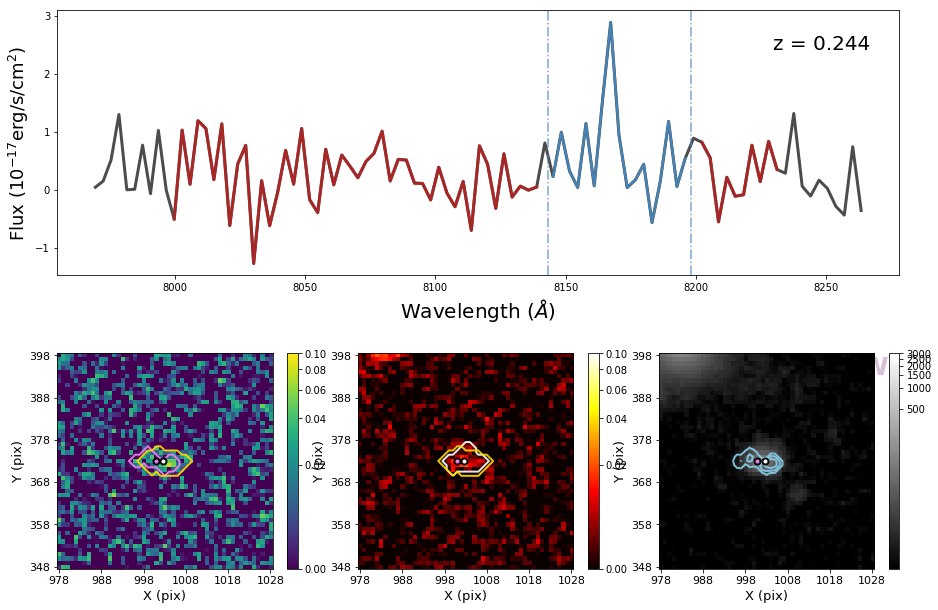

In [71]:
num = 231
datacube.centroid_analysis(num, centroid_type="ISO-D", sn_thre=1.5, smooth=False)

stddev emission: 0.016 / continuum: 0.004
Centroid EM: (843.16+/-0.15, 1233.84+/-0.15)
Centroid CON: (842.99+/-0.10, 1234.15+/-0.10)


{'diff_angle': 13.288737765888577,
 'cen_offset': 0.3443082252389126,
 'diff_angle_std': 29.48601548012825,
 'cen_offset_std': 0.17719067173197278,
 'pa': 28.583383547044832,
 'clus_cen_angle': 41.87212131293341,
 'dist_clus_cen': 206.4139509814216}

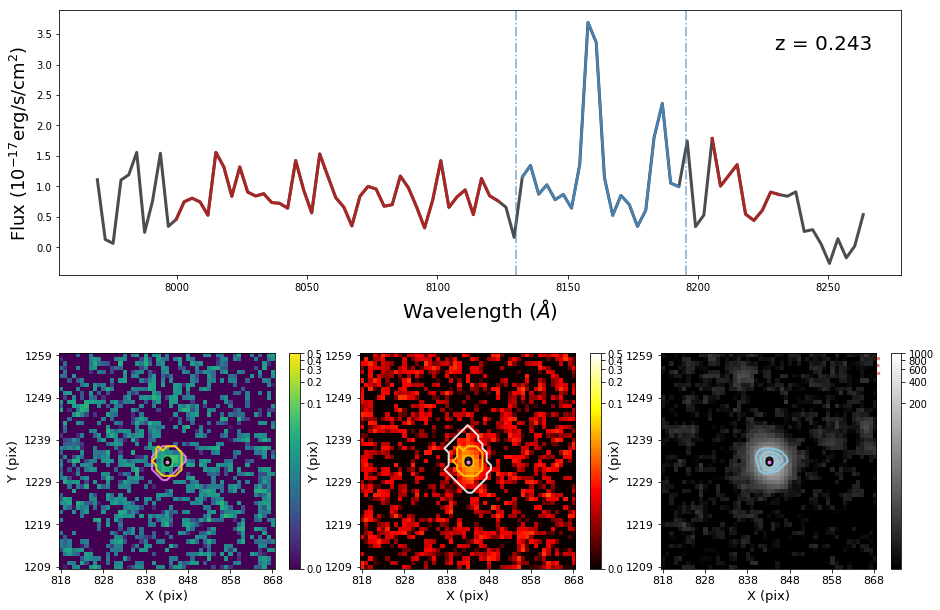

In [106]:
num = 667
datacube.centroid_analysis(num, centroid_type="ISO-D", morph_cen=True, smooth=False)

In [75]:
datacube.centroid_analysis_all(Num_v_all, nums_obj=Num_v_all, centroid_type="ISO-D", morph_cen=False, verbose=False)
datacube.centroid_analysis_all(Num_v_all, nums_obj=Num_v_all, centroid_type="ISO-D", morph_cen=True, verbose=False)

In [80]:
z_V =  datacube.get_CC_result_best('z_best', 'Ha-NII_gauss', Num_v_all)
datacube.result_centroid.keys()

dict_keys(['ISO-D', 'ISO-Dm'])

In [94]:
datacube.save_centroid_measurement(Num_v, save_path='./proc/', ID_field='D')

Save centroid measurement as catalog:  ./proc/centroid_analysis_A2465C.txt


In [77]:
diff_angle_iso_d = datacube.get_centroid_result('diff_angle', 'ISO-D', fill_value=0)
cen_off_iso_d = datacube.get_centroid_result('cen_offset', 'ISO-D', fill_value=0)
cen_off_std_iso_d = datacube.get_centroid_result('cen_offset_std', 'ISO-D', fill_value=99)

diff_angle_iso_dm = datacube.get_centroid_result('diff_angle', 'ISO-Dm', fill_value=0)
cen_off_iso_dm = datacube.get_centroid_result('cen_offset', 'ISO-Dm', fill_value=0)
cen_off_std_iso_dm = datacube.get_centroid_result('cen_offset_std', 'ISO-Dm', fill_value=99)

In [81]:
def condition_1(cen_off, cen_off_std, z_V):
    return (cen_off>1) & (cen_off>3*cen_off_std) & (abs(z_V-0.245)<0.015) & (z_V>0.22)

def condition_2(cen_off, cen_off_std, z_V):
    return (cen_off>1+3*cen_off_std) & (abs(z_V-0.245)<0.015)

cond = condition_1

cond_d = cond(cen_off_iso_d, cen_off_std_iso_d, z_V)
cond_dm = cond(cen_off_iso_dm, cen_off_std_iso_dm, z_V)

d_angle_d1 = diff_angle_iso_d[cond_d]
d_angle_dm1 = diff_angle_iso_dm[cond_dm]

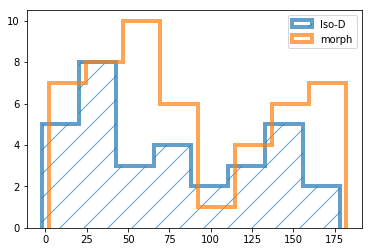

In [84]:
plt.hist(d_angle_d1-2, bins=np.linspace(0,180,9)-2,histtype="step",hatch="/", lw=4, alpha=0.7,label='Iso-D')
plt.hist(d_angle_dm1+2, bins=np.linspace(0,180,9)+2,histtype="step", lw=4, hatch="", alpha=0.7,label='morph')
plt.legend()

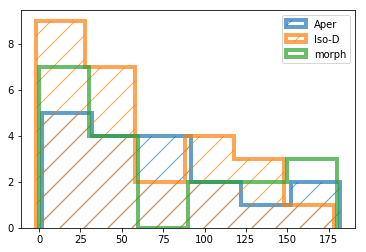

In [113]:
plt.hist(d_angle_a1+2, bins=np.linspace(0,180,7)+2,histtype="step", hatch="/", lw=4, alpha=0.7,label='Aper')
plt.hist(d_angle_d1-2, bins=np.linspace(0,180,7)-2,histtype="step",hatch="/", lw=4, alpha=0.7,label='Iso-D')
plt.hist(d_angle_dm1, bins=np.linspace(0,180,7),histtype="step", lw=4, hatch="", alpha=0.7,label='morph')
plt.legend()